0
1
2
3
4
5


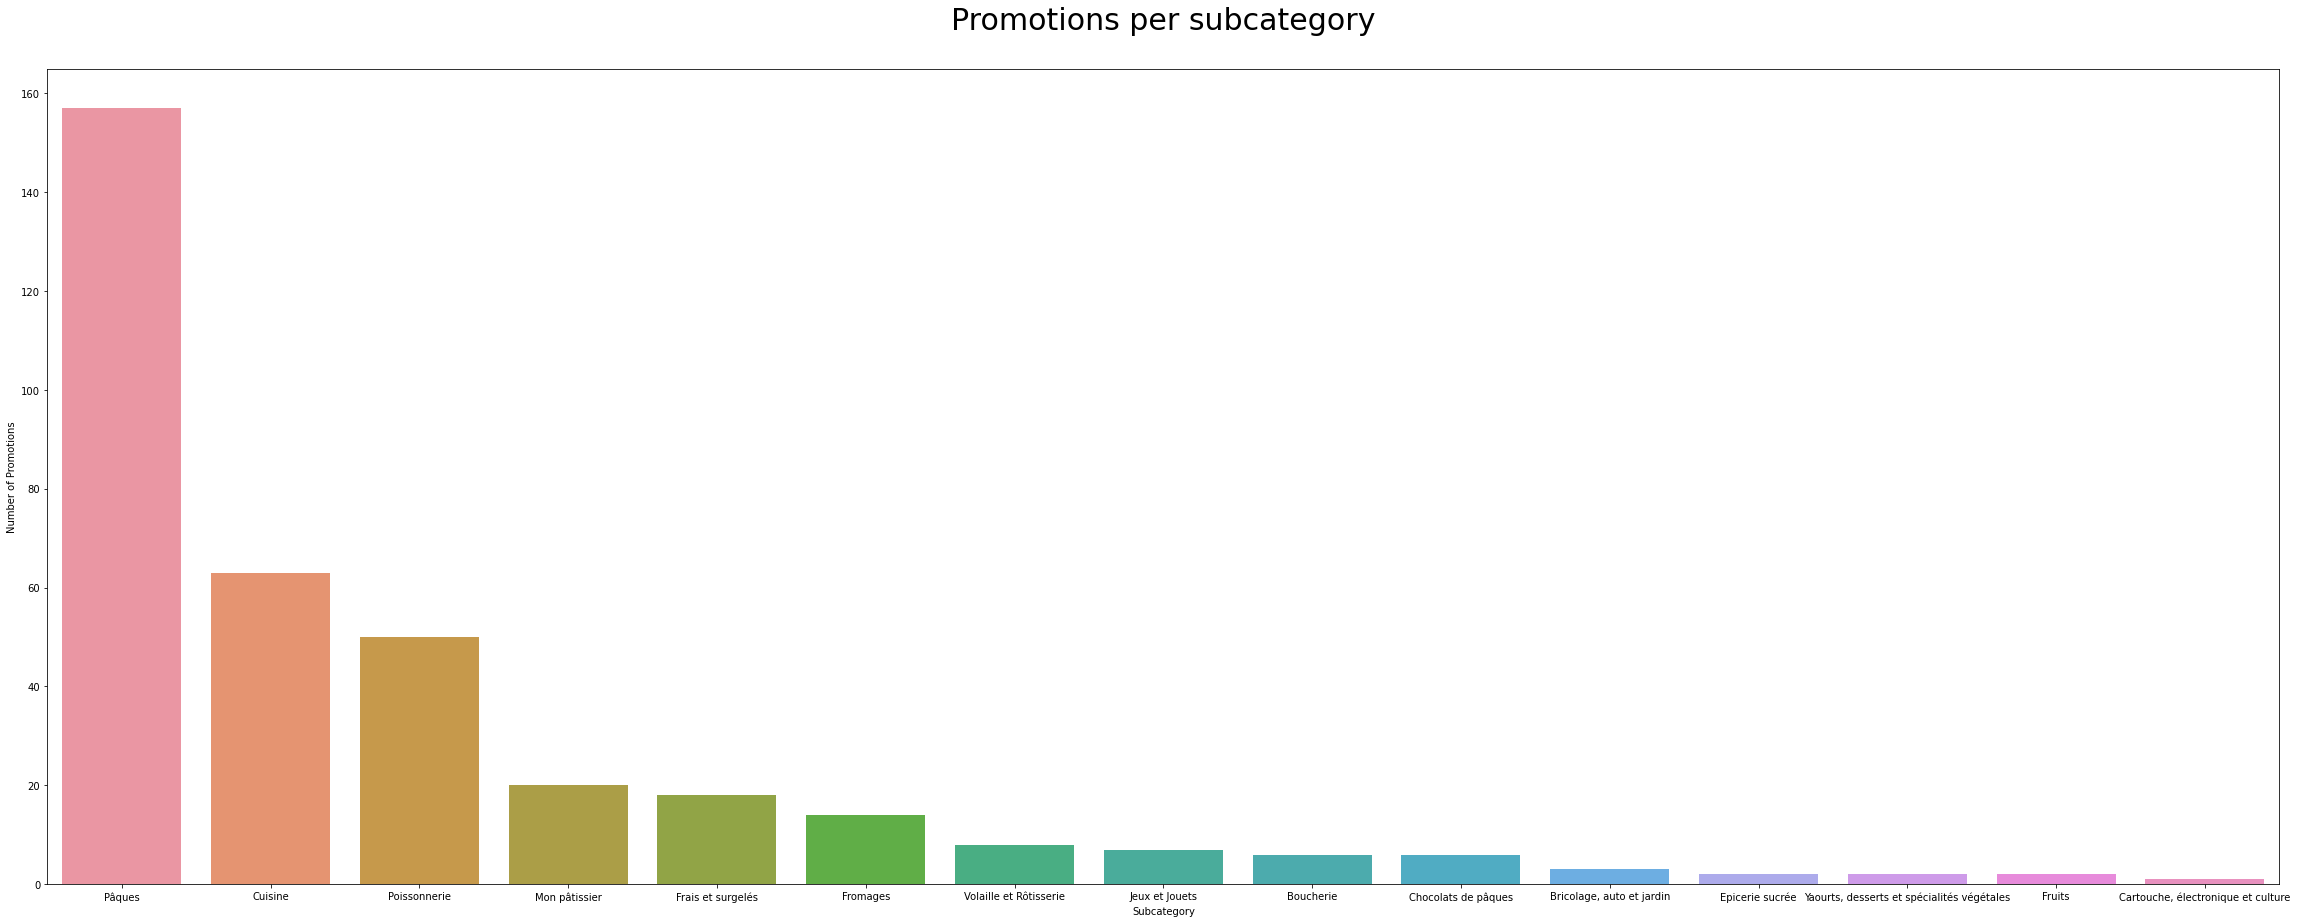

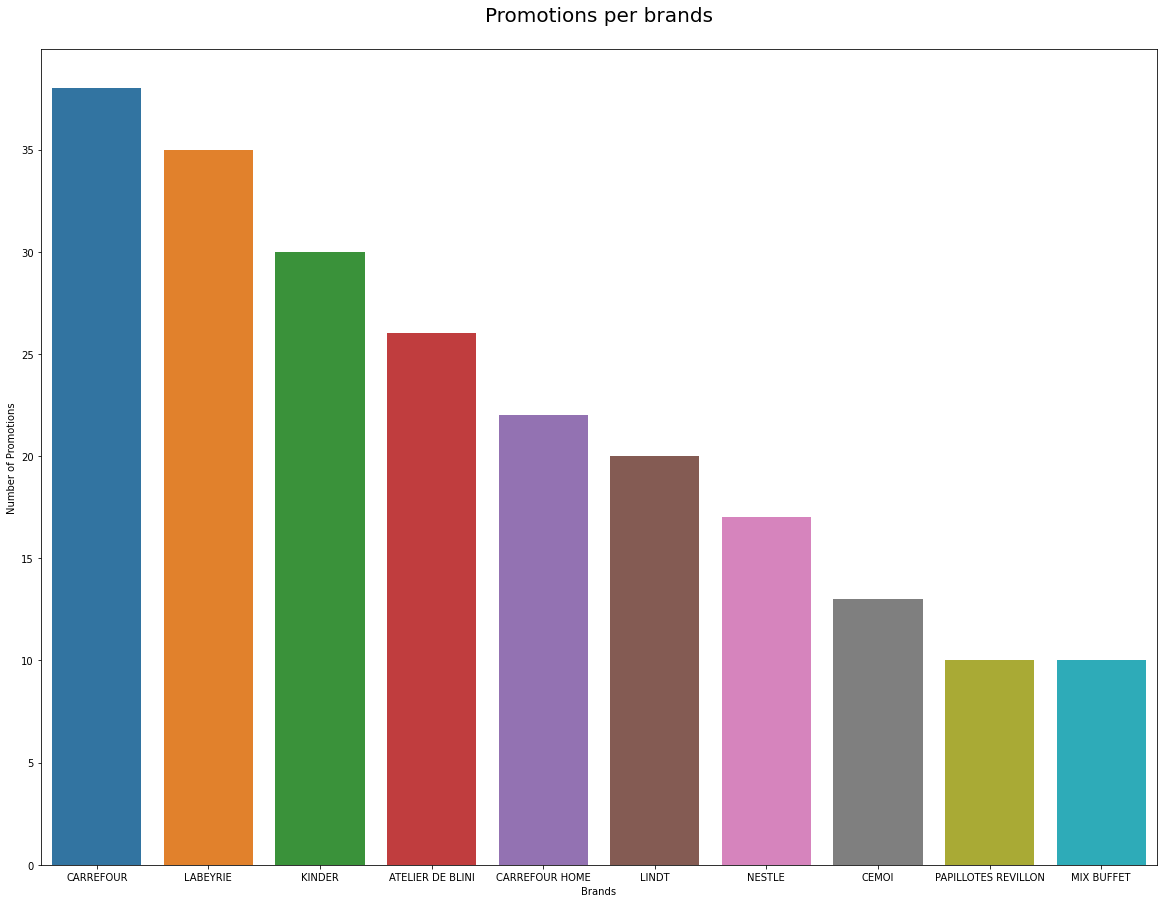

There are 141 promotions without any discounts


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 11 15:22:58 2020

@author: Camille
"""

# import libraries
import requests as r
import json
import pandas as pd
from bs4 import BeautifulSoup
import os
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns

#Defining functions

#Finding how many pages need to be scrapped
def pages_number(url):
    html = r.get(url).content;
    soup = BeautifulSoup(html)
    # i = number of products promoted
    number=[i.text.replace('\n','') for i in soup.select('h5')]
    i=int(number[0].split()[0])
    # checking number of product per page
    product_name=[i.text.replace('\n','') for i in soup.select('ul h2')]
    # n = number of pages of promo
    n=math.ceil(i/len(product_name))
    return n

#Scrapping pages
def scrapping():
    df_final=pd.DataFrame()
    for i in range(n+1):
        url=f"https://www.carrefour.fr/promotions?noRedirect=0&page={i}"
        headers=f"""accept: application/json, text/plain, */*
        accept-encoding: gzip, deflate, br
        accept-language: fr-FR,fr;q=0.9,en-US;q=0.8,en;q=0.7
        cache-control: no-cache
        cookie: TCPID=119551614271772534656; _ga=GA1.2.1334375845.1556892869; cookieIDCrfOne=V12019531614280.2021166067845266; TC_OPTOUT=0@@@@@@ALL; already_visitedOne=1; visid_incap_1982952=0RjOMFJXRuKKO5znr4FgKeRMzFwAAAAAQUIPAAAAAAD6n2mvQU/sqwDmJkARHJBk; tc_cj_v2=m_iZZZ%22**%22%27%20ZZZKOOPRSLRPQNRRZZZ%5D777_rn_lh%5BfyfcheZZZ222H.*-/%24-%7B+%7B-%24.H%7D*%28ZZZKOOQLKRRRQLLMZZZ%5D777m_iZZZ%22**%22%27%20ZZZKOQRKMKMSQNRKZZZ%5D; datadome=MV~uTOOCnVIzfg.ULn2qjQwiYrYCKiCPqVlIXhkojIZNBB1zJzAjb_LCHT2CCYufdPeKF5Omu7~Z9jwshB52Hgn-fgLks.1wkrj4LccckQ; _cs_c=0; _cs_id=9566bfd8-1a78-a240-f0bb-e8015b3551ba.1556892869.3.1578131399.1578131399.1.1591056869072; visid_incap_441619=vrnUei+7RLiL2Xr3UUmTzfgij14AAAAAQUIPAAAAAABOtZUZlXTnCzjXe1PMdHUQ; visid_incap_1722501=z8YspOTjRLmNxY1jMdqc2voij14AAAAAQUIPAAAAAAAz5k9o0TPe5INp8+VLBGMZ; FRONTONE_USER=1589030911; FRONTONE_SESSID=b63750e3dfbafa4034d6cf3e8d2d558c; FRONTONE_SESSION_ID=e63380316c097c37050207ec718741fff9259edc; nlbi_441619=ufhBSxHyMEoXfsE3Jv8P3AAAAABTP2fpV1zP/JtDBdulhzAa; incap_ses_766_441619=MtovSnQkoT9/JNpoFmKhCqEbkF4AAAAAc7N3y/70ukqqav4TtYvpDQ==; pageCounterCrfOne=1; QueueITAccepted-SDFrts345E-V3_prodevent=EventId%3Dprodevent%26QueueId%3D54e303e1-7614-444d-8c92-dbdad2d61b4a%26RedirectType%3Dsafetynet%26IssueTime%3D1586502577%26Hash%3D21030c8a62ca512d24f5dcbcaacc1f41b3c042a6999d987071870a39842d6678
        dnt: 1
        pragma: no-cache
        referer: https://www.carrefour.fr/promotions?noRedirect=1&page={i}
        sec-fetch-dest: empty
        sec-fetch-mode: cors
        sec-fetch-site: same-origin
        user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36
        x-requested-with: XMLHttpRequest"""
        headers=dict([i.strip().split(': ') for i in headers.split('\n')])
        results=r.get(url, headers=headers).json()
        df=pd.json_normalize(results['data'])
        df['difference'] = df['attributes.promotion.messageArgs.initialPrice'] - df['attributes.promotion.messageArgs.discountedPrice']
        df1 = df[['attributes.ean','attributes.title', 'attributes.brand',  'attributes.categories','attributes.availability.purchasable', 'attributes.promotion.label', 'attributes.promotion.bestQuantity', 'attributes.promotion.messageArgs.discountedPrice','attributes.promotion.messageArgs.initialPrice', 'difference', 'attributes.promotion.discountLabel','attributes.price.perUnitLabel','attributes.promotion.promoStartDate','attributes.promotion.promoEndDate']]
        df_final=df_final.append(df1)
        time.sleep(2)
        print(i)
    return df_final
    
def resetting_index(df_final):
    df_final=df_final.reset_index() 
    df_final.rename(columns={"index":"old_index"})
    return df_final

#cleaning data
def clean_cat(df_final):
    categories=[]
    for k in df_final.index:
        categories.append([i['label'] for i in df_final['attributes.categories'][k]])
        category=[i[0] for i in categories]
        subcategory=[i[1] for i in categories]
    df_final['category']=category
    df_final['subcategory']=subcategory
    df_final=df_final.drop(['attributes.categories'], axis=1)
    return df_final

#renaming col
def renaming_col(df_final):
    df_ok=df_final.rename(columns={"attributes.ean": "EAN", "attributes.title": "product_name", 'attributes.brand':'brand', 'attributes.availability.purchasable':'purchasable', 'attributes.promotion.label':'promotion_type', 'attributes.promotion.bestQuantity': 'best_quantity', 'attributes.promotion.messageArgs.discountedPrice': 'discounted_price', 'attributes.promotion.messageArgs.initialPrice':'initial_price', 'attributes.promotion.discountLabel':'promo_description','attributes.price.perUnitLabel':'price_per_unit','attributes.promotion.promoStartDate':'Start_Date', 'attributes.promotion.promoEndDate':'End_Date'   })
    df_ok=df_ok[['EAN', 'product_name', 'brand', 'category', 'subcategory', 'purchasable', 'promotion_type', 'promo_description', 'best_quantity','price_per_unit', 'discounted_price', 'initial_price', 'difference','Start_Date','End_Date']]
    return df_ok

# data analysis
def group_category(df_final):
    df_final.groupby('category').mean()
    df_group=df_final.groupby(['category','subcategory']).count()['EAN']
    df_group=pd.DataFrame(df_group).rename(columns={'EAN':'count_promotion'})
    return df_group

# save final df into a csv
def save_df():
    os.chdir('C:/Users/Camille/Documents/Ecole/Ironhack/Week 3/Web_Scrapping_project/Output')
    df_final.to_csv('Carrefour_promo.csv')
    
#creating graphs
    
def graph_subcat():
    df_subcategory=pd.DataFrame(df_final.subcategory.value_counts()).reset_index().rename(columns={'index':'Subcategory', 'subcategory':'Number of Promotions'})
    fig, ax = plt.subplots(figsize=(40,15))
    graph_subcat = sns.barplot(data=df_subcategory, x='Subcategory', y='Number of Promotions')
    plt.title('Promotions per subcategory'+ '\n', fontsize=30)
    return graph_subcat

def graph_top_brands():
    brands=pd.DataFrame(df_final.brand.value_counts()).nlargest(10, 'brand').reset_index().rename(columns={'index':'Brands', 'brand':'Number of Promotions'})
    fig, ax = plt.subplots(figsize=(20,15))
    graph_brands = sns.barplot(data=brands, x='Brands', y='Number of Promotions')
    plt.title('Promotions per brands'+ '\n', fontsize=20)    
    return graph_brands

#saving graphs

def save_viz(barchart,title):
    os.chdir('C:/Users/Camille/Documents/Ecole/Ironhack/Week 3/Web_Scrapping_project/Output')
    fig = barchart.get_figure()
    fig.savefig(title+ '.png')
    plt.show()

    
#calling functions
if __name__ == '__main__':
    n=pages_number('https://www.carrefour.fr/promotions?noRedirect=0&page=0')
    df_final=scrapping()
    df_final=resetting_index(df_final)
    df_final=clean_cat(df_final)
    df_final=renaming_col(df_final)
    df_group=group_category(df_final)
    save_df()
    #graphs
    subcat=graph_subcat()
    top_brands=graph_top_brands()
    #saving graphs
    save_viz(subcat,'Promotions per subcategory' )
    save_viz(top_brands, 'Promotion per brands (Top 10)')

#computing promos without lower price
dfnull=df_final.loc[df_final['difference'] == float(0)]
print(f"There are {len(dfnull)} promotions without any discounts")

In [2]:
df_final

,EAN,product_name,brand,category,subcategory,purchasable,promotion_type,promo_description,best_quantity,price_per_unit,discounted_price,initial_price,difference,Start_Date,End_Date
0,0000041007563,Chocolat de Pâques lapin NESTLE,NESTLE,Epicerie Sucrée,Chocolats de pâques,True,Le 2ème à -50%,soit 2 à 4.18€ au lieu de 5.58€,2,32.82 € / Kilogramme,4.18,5.58,1.40,2020-04-07T00:00:00+0200,2020-07-05T23:59:00+0200
1,0000080135517,Chocolat de Pâques au lait lapin KINDER,KINDER,Epicerie Sucrée,Chocolats de pâques,True,Le 2ème à -50%,soit 2 à 3.73€ au lieu de 4.98€,2,22.64 € / Kilogramme,3.73,4.98,1.25,2020-04-07T00:00:00+0200,2020-07-05T23:59:00+0200
2,0000059945741,Chocolat de Pâques Œufs NESTLE,NESTLE,Epicerie Sucrée,Chocolats de pâques,True,Le 2ème à -50%,soit 2 à 2.23€ au lieu de 2.98€,2,29.80 € / Kilogramme,2.23,2.98,0.75,2020-04-07T00:00:00+0200,2020-07-05T23:59:00+0200
3,3292070008551,Houmous bio BLINI,ATELIER DE BLINI,Bio et Ecologie,Frais et surgelés,True,Prenez en 3 = Payez en 2,soit 3 à 6.98€ au lieu de 10.47€,3,21.81 € / Kilogramme,6.98,10.47,3.49,2020-04-03T00:00:00+0200,2020-04-13T23:59:00+0200
4,3292070009275,Blinis bio x8 ATELIER BLINI,ATELIER DE BLINI,Bio et Ecologie,Frais et surgelés,True,Prenez en 3 = Payez en 2,soit 3 à 5.00€ au lieu de 7.50€,3,15.62 € / Kilogramme,5.00,7.50,2.50,2020-04-03T00:00:00+0200,2020-04-13T23:59:00+0200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,8001691494958,"Verre ""Azulejos"" à motif 36 cl",PP NO NAME,"Maison, Loisir, Textile",Cuisine,True,Vu en catalogue,soit 1 à 1.60€ au lieu de 1.60€,1,1.60 € / Pièce,1.60,1.60,0.00,2020-03-24T00:00:00+0100,2020-04-27T23:59:00+0200
355,8001691494927,"Verre ""Azulejos"" à motif bleu 36 cl",PP NO NAME,"Maison, Loisir, Textile",Cuisine,True,Vu en catalogue,soit 1 à 1.60€ au lieu de 1.60€,1,1.60 € / Pièce,1.60,1.60,0.00,2020-03-24T00:00:00+0100,2020-04-27T23:59:00+0200
356,8421134090309,Poupée Magic Tears Fantasy Maison Tototte CRY ...,IMC TOYS,"Maison, Loisir, Textile",Jeux et Jouets,True,Vu en catalogue,soit 1 à 17.90€ au lieu de 17.90€,1,17.90 € / Pièce,17.90,17.90,0.00,2020-03-31T00:00:00+0200,2020-04-14T23:59:00+0200
357,4039784342033,KARCHER - Détergent vitres formule 3-en-1 - 62...,KARCHER,"Maison, Loisir, Textile","Bricolage, auto et jardin",True,Prenez en 4 = Payez en 3,soit 4 à 16.50€ au lieu de 22.00€,4,5.50 € / Pièce,16.50,22.00,5.50,2020-03-31T00:00:00+0200,2020-04-13T23:59:00+0200


In [3]:
df_group

count_promotion
category                subcategory                                                
Bio et Ecologie         Epicerie sucrée                                           2
                        Frais et surgelés                                        18
Crémerie                Fromages                                                 14
                        Yaourts, desserts et spécialités végétales                2
Epicerie Sucrée         Chocolats de pâques                                       6
Fruits et Légumes       Fruits                                                    2
Maison, Loisir, Textile Bricolage, auto et jardin                                 3
                        Cartouche, électronique et culture                        1
                        Cuisine                                                  63
                        Jeux et Jouets                                            7
Pains et Pâtisseries    Mon pâtissier                                            20
Traiteur                Pâques                                                  157
Viandes et Poissons     Boucherie                                                 6
                        Poissonnerie                                             50
                        Volaille et Rôtisserie                                    8

In [4]:
dfnull

,EAN,product_name,brand,category,subcategory,purchasable,promotion_type,promo_description,best_quantity,price_per_unit,discounted_price,initial_price,difference,Start_Date,End_Date
13,3276554568076,Fraise Gariguette,None,Fruits et Légumes,Fruits,True,Vu en catalogue,soit 1 à 1.99€ au lieu de 1.99€,1,7.96 € / Kilogramme,1.99,1.99,0.0,2020-04-03T00:00:00+0200,2020-04-12T23:59:00+0200
19,3266980053062,Pavés de biche marinés à la truffe SAVEURS FOR...,SAVEURS FORESTIERES,Viandes et Poissons,Boucherie,True,A saisir !,soit 1 à 7.95€ au lieu de 7.95€,1,31.80 € / Kilogramme,7.95,7.95,0.0,2020-04-03T00:00:00+0200,2020-04-14T23:59:00+0200
20,3276559959671,Gigot d'agneau entier,None,Viandes et Poissons,Boucherie,True,Vu en catalogue,soit 1 à 20.48€ au lieu de 20.48€,1,9.31 € / Kilogramme,20.48,20.48,0.0,2020-04-03T00:00:00+0200,2020-04-14T23:59:00+0200
35,3266980053086,Biche à la crème aux morilles LE GAULOIS,SAVEURS FORESTIERES,Viandes et Poissons,Boucherie,True,A saisir !,soit 1 à 7.95€ au lieu de 7.95€,1,31.80 € / Kilogramme,7.95,7.95,0.0,2020-04-03T00:00:00+0200,2020-04-14T23:59:00+0200
36,3266980021481,Foies de volaille confits LE GAULOIS,LE GAULOIS,Viandes et Poissons,Volaille et Rôtisserie,True,30% économisés,1.38€ sur la carte pour chaque produit acheté,1,7.67 € / Kilogramme,4.60,4.60,0.0,2020-04-03T00:00:00+0200,2020-04-13T23:59:00+0200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,8001691479597,"Verre ""Ethnic"" à motif 31 cl",None,"Maison, Loisir, Textile",Cuisine,True,Vu en catalogue,soit 1 à 1.40€ au lieu de 1.40€,1,1.40 € / Pièce,1.40,1.40,0.0,2020-03-24T00:00:00+0100,2020-04-27T23:59:00+0200
354,8001691494958,"Verre ""Azulejos"" à motif 36 cl",PP NO NAME,"Maison, Loisir, Textile",Cuisine,True,Vu en catalogue,soit 1 à 1.60€ au lieu de 1.60€,1,1.60 € / Pièce,1.60,1.60,0.0,2020-03-24T00:00:00+0100,2020-04-27T23:59:00+0200
355,8001691494927,"Verre ""Azulejos"" à motif bleu 36 cl",PP NO NAME,"Maison, Loisir, Textile",Cuisine,True,Vu en catalogue,soit 1 à 1.60€ au lieu de 1.60€,1,1.60 € / Pièce,1.60,1.60,0.0,2020-03-24T00:00:00+0100,2020-04-27T23:59:00+0200
356,8421134090309,Poupée Magic Tears Fantasy Maison Tototte CRY ...,IMC TOYS,"Maison, Loisir, Textile",Jeux et Jouets,True,Vu en catalogue,soit 1 à 17.90€ au lieu de 17.90€,1,17.90 € / Pièce,17.90,17.90,0.0,2020-03-31T00:00:00+0200,2020-04-14T23:59:00+0200
